In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Data Analysis

In [2]:
dataset_path = '../data/classification_dataset.csv'
df = pd.read_csv(dataset_path)
df

,text,l1,l2,l3
0,"Ronald \""Ron\"" D. Boire is an American busines...",Agent,Person,BusinessPerson
1,Astra 1KR is one of the Astra geostationary sa...,Place,Satellite,ArtificialSatellite
2,Cycleryon is an extinct genus of decapod crust...,Species,Animal,Crustacean
3,"Angela Maria of the Heart of Jesus, also calle...",Agent,Cleric,Saint
4,"William Garnet \""Bing\"" Coughlin – Canadian Wo...",Agent,Artist,ComicsCreator
...,...,...,...,...
342776,The Messenger is a quarterly magazine publishe...,Work,PeriodicalLiterature,Magazine
342777,"Seren \""Haf\"" Gibson (born in Ruthin, Denbighs...",Agent,Actor,AdultActor
342778,Anne Margrethe Strømsheim (née Bang) (1914 – 6...,Agent,Person,MilitaryPerson
342779,116 Sirona is a somewhat large and bright-colo...,Place,CelestialBody,Planet


## Overall checks

In [3]:
# check for repeated data

if (len(df) == len(df.text.unique())):
    print('All texts are unique')

All texts are unique


In [4]:
# check for inconsistencies in labels

inconsistencies_exist = False

for l3_label in df.l3.unique():
    all_from_label = df[df['l3'] == l3_label]
    
    if not len(all_from_label.l2.unique()) == 1 and len(all_from_label.l1.unique()) == 1:
        print(f'Problem with label {l3_label}')
        inconsistencies_exist = True
        
if not inconsistencies_exist:
    print('No label inconsistencies were found.')

No label inconsistencies were found.


## Data Distribution

In [5]:
df.l1.value_counts()

Agent             177341
Place              65128
Species            31149
Work               29832
Event              27059
SportsSeason        8307
UnitOfWork          2497
TopicalConcept      1115
Device               353
Name: l1, dtype: int64

### Looking at L1

<AxesSubplot:>

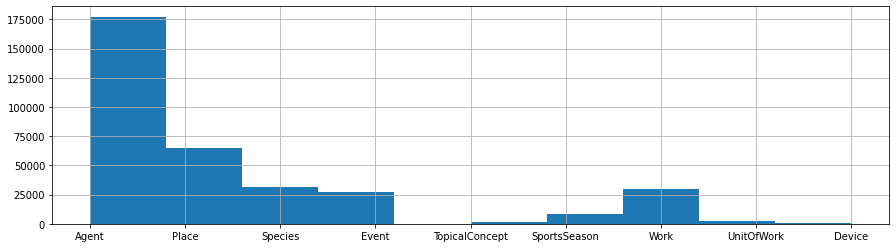

In [6]:
df.l1.hist(figsize=(15,4))

Data does not seem very well balanced in L1

### Looking at L2

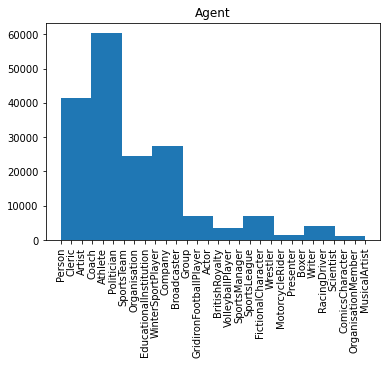

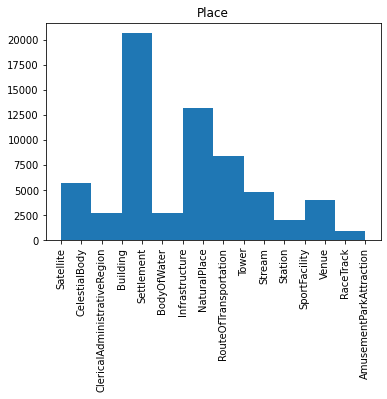

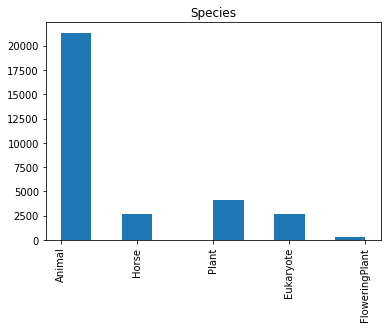

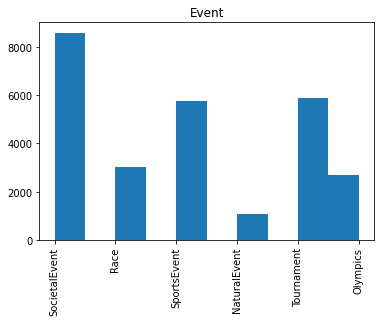

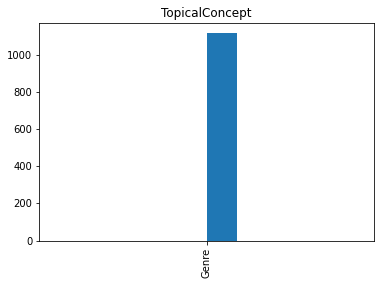

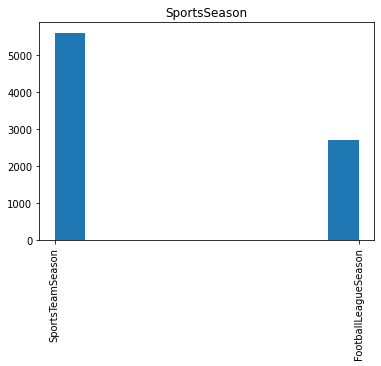

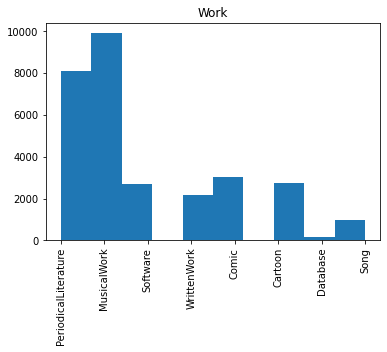

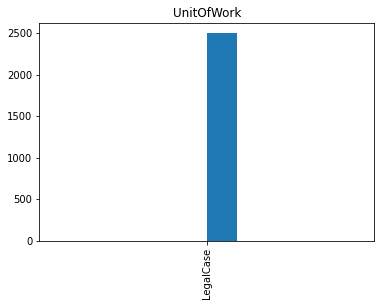

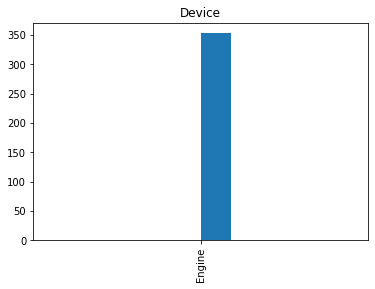

In [7]:
for l1_label in df.l1.unique():
    p = plt.hist(df[df['l1'] == l1_label].l2)
    plt.title(l1_label)
    plt.xticks(rotation='vertical')

    plt.show()


Three labels in L2 have only one L3:
- TopicalConcept only has Genre.
- UnitOfWork only has LegalCase
- Device only has Engine

In [8]:
for l1_label in df.l1.unique():
    if len(df[df['l1'] == l1_label].l3.unique()) == 1:
        l2_label = df[df['l1'] == l1_label].l2.unique()
        l3_label = df[df['l1'] == l1_label].l3.unique()
        print(f'{l1_label} - {l2_label} - {l3_label}')

TopicalConcept - ['Genre'] - ['MusicGenre']
UnitOfWork - ['LegalCase'] - ['SupremeCourtOfTheUnitedStatesCase']
Device - ['Engine'] - ['AutomobileEngine']


And those same L2 labels have only one child label in L3

### Looking at L3

As there are too many labels in L3, it's easier to look at the counts in a table instead of ploting them.

In [24]:
df['l3'].value_counts()

Manga                    2700
AcademicJournal          2700
Planet                   2700
GolfPlayer               2700
FootballMatch            2700
                         ... 
Cycad                     204
AnimangaCharacter         203
BeachVolleyballPlayer     194
CanadianFootballTeam      190
BiologicalDatabase        187
Name: l3, Length: 219, dtype: int64

Clearly a high imbalance in L3. Number of datapoints per label vary from 187 to 2700.

## Looking at label distribution

### Number of labels in each level

In [10]:
print(f'Number of l1 labels: {len(df.l1.unique())}')

Number of l1 labels: 9


In [11]:
print(f'Number of l2 labels: {len(df.l2.unique())}')

Number of l2 labels: 70


In [12]:
print(f'Number of l3 labels: {len(df.l3.unique())}')

Number of l3 labels: 219


### Label distribution in L1

In [13]:
# counts for how many L3 labels each L2 label has
counts = list()

for label in df.l1.unique():
    size = len(df[df['l1'] == label].l3.unique())
    counts.append((label, size))
    
counts = sorted(counts, key=lambda x: x[1])
counts_df = pd.DataFrame(counts, columns=['L1 label', 'L3 count'])

<AxesSubplot:xlabel='L1 label'>

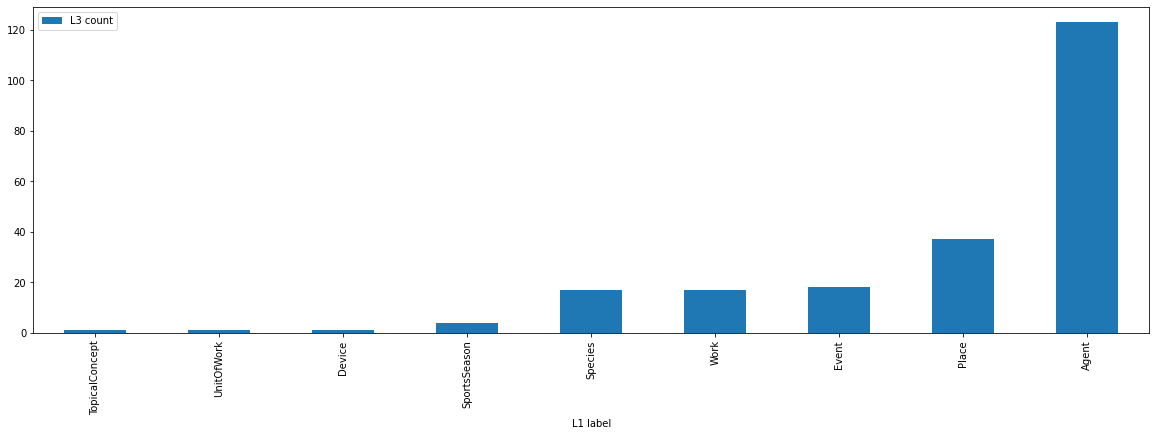

In [14]:
counts_df.plot.bar(0, 1, figsize=(20,6))

Agent and Place are the L1 labels with the most L3 labels

### Label distribution in L2

In [15]:
# counts for how many L3 labels each L2 label has
counts = list()

for label in df.l2.unique():
    size = len(df[df['l2'] == label].l3.unique())
    counts.append((label, size))
    
counts = sorted(counts, key=lambda x: x[1])
counts_df = pd.DataFrame(counts, columns=['L2 label', 'L3 count'])

<AxesSubplot:xlabel='L2 label'>

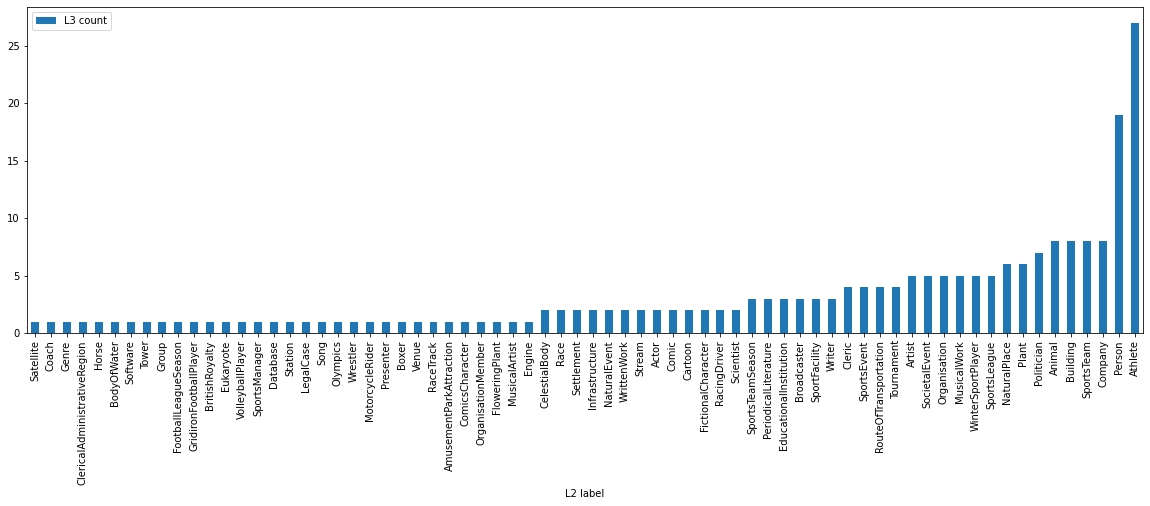

In [16]:
counts_df.plot.bar(0, 1, figsize=(20,6))

Person and Athlete are the L2 labels with the most number of L3 labels.

## Possible solutions

I see a few imediate ways to solve this problem. A single classifier one and a couple multi-classifier ones.

### 1) Single Classifier

The most straightforward solution to solve this problem is building a single multiclass classifier using the text as data and the L3 values as targets. I believe this is called flat classification in the literature. The main drawback from this approach is that when you ignore the L1 and L2 labels, you might be missing on a lot of information shared bewteen the classes. 

For instance, it's possible that texts with L3 GolfPlayer, Gymnast and Cyclist has shared information, because they all have the parent classes Athlete and Person. This approach ignores that shared information.

Another problem with this approach is that the imbalance in the data distribution is very high in L3. A possible alternative for that is to do some undersample in the classes that have too many samples.

### 2) One classifier per label

Another approach is to break down the classification problem into multiple classifiers.

One possibility would be to have:

- one classifier to classify into the L1 labels
- one classifier per each L1 label, to classify into their L2 labels
- one classifier per each L2 label, to classify into their L2 labels.

That would total 80 classifiers. However, this sounds like an overkill, especially because there is a lot of imbalance in the data and in the number of classes.

### 3) Smarter multi-classifier approach

If I were to break the problem into multiple classifiers, I would make use of the data distribution as some sort of entropy to identify the classifiers that have the most potential.

For starters, I would build separate classifiers to classify the L3 labels the following L2 labels:

- Person
- Athlete

The reason for that is that those have the most number of distinct sublabels, so the chance that those sublabels share information of their parent label is higher.

Similarly, the following L1 labels would have their own classifiers:

- Agent (to classify between Person, Athlete and Other)
- Place (to classify between all its L3 labels)

That would leave me with a total of seven classifier, as shown in the figure below.

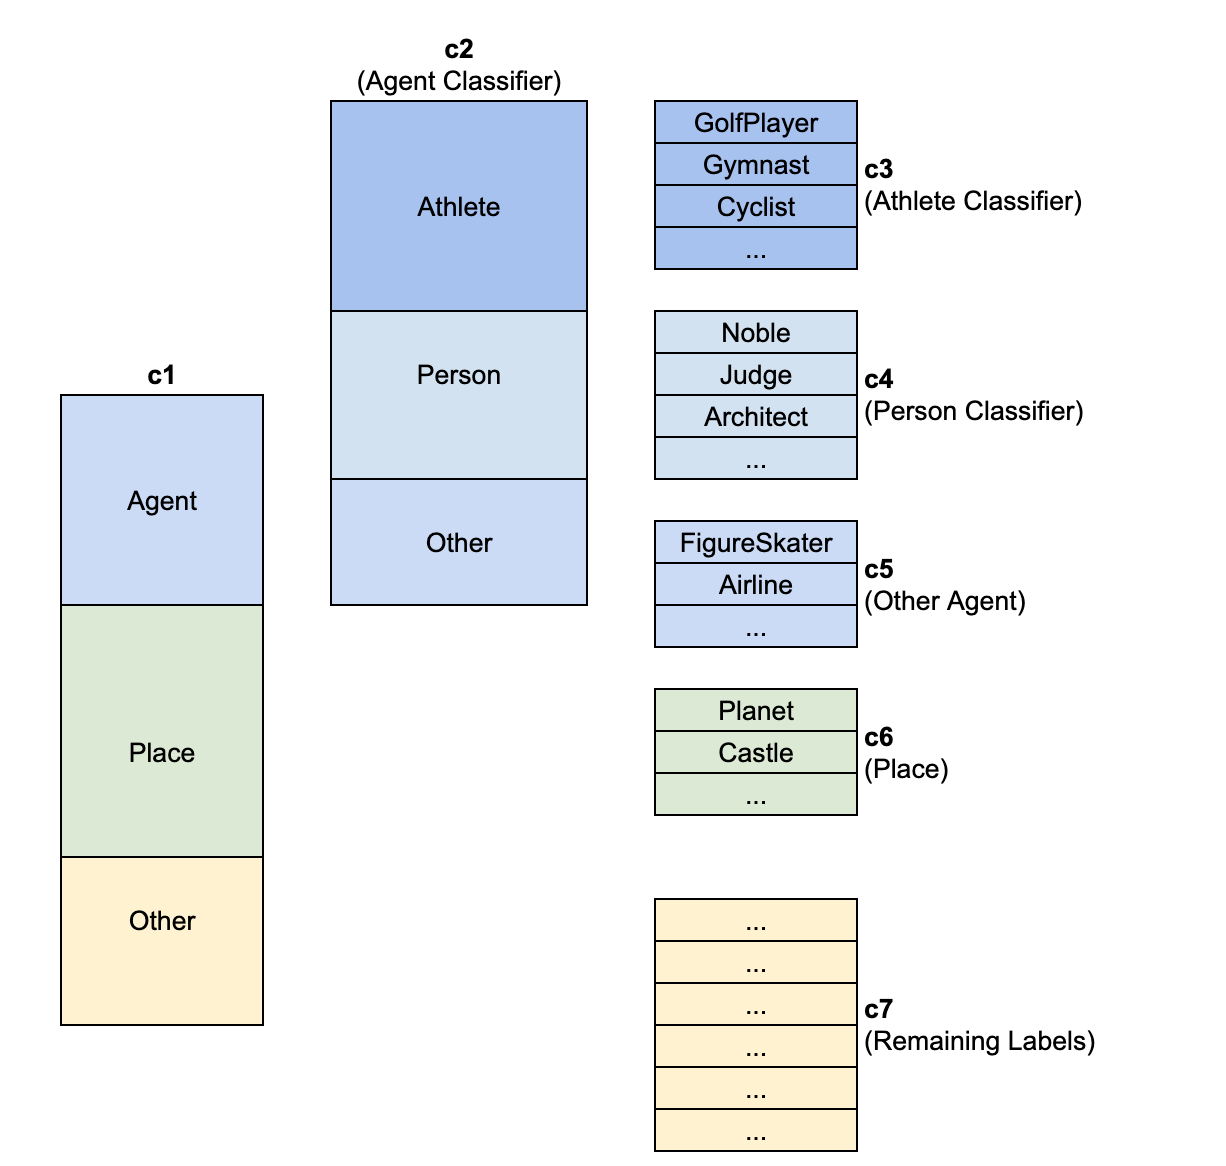

In [22]:
diagram_path = 'classifiers_diagram.png'
display(Image(filename=diagram_path))